# Image segmentation <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` and `NCI` environments
* **Products used:** 
[ga_s2am_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2am_ard_3), 
[ga_s2bm_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2bm_ard_3)

## Background
In the last two decades, as the spatial resolution of satellite images has increased, remote sensing has begun to shift from a focus on pixel-based analysis towards Geographic Object-Based Image Analysis (GEOBIA), which aims to group pixels together into meaningful image-objects. 
There are two advantages to a GEOBIA worklow; one, we can reduce the 'salt and pepper' effect typical of classifying pixels; and two, we can increase the computational efficiency of our workflow by grouping pixels into fewer, larger, but meaningful objects. 
A review of the emerging trends in GEOBIA can be found in [Chen et al. (2017)](https://www.tandfonline.com/doi/abs/10.1080/15481603.2018.1426092).

## Description
This notebook demonstrates two methods for conducting [image segmentation](https://en.wikipedia.org/wiki/Image_segmentation), which is a common image analysis technique used to transform a digital satellite image into objects. 
In brief, image segmentation aims to partition an image into segments, where each segment consists of a group of pixels with similar characteristics. 
A number of algorithms exist to perform image segmentation, one of which are shown here:

1. [Quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift), implemented through the python package `scikit-image`

> **Note:** Image segmentation at very large scales can be both time and memory intensive, and the examples shown here will become prohibitively time consuming at scale. 
The notebook [Tiled, Parallel Image Segmentation](https://github.com/GeoscienceAustralia/dea-notebooks/blob/chad/segmentation/parallel_segmentation.ipynb) builds upon the image segmentation algorithm developed by [Shepherd et al. (2019)](https://www.mdpi.com/2072-4292/11/6/658) to run image segmentation across multiple cpus.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import numpy as np
import scipy
import matplotlib.pyplot as plt
from osgeo import gdal
from datacube.utils.cog import write_cog
from datacube.helpers import write_geotiff
from skimage.segmentation import quickshift

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Image_segmentation')


## Load Sentinel 2 data from the datacube

Here we are loading in a timeseries of `Sentinel 2` satellite images through the datacube API using the [load_ard](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Frequently_used_code/Using_load_ard.ipynb) function. This will provide us with some data to work with.

In [3]:
# Create a query object
query = {
    'x': (153.35, 153.50),
    'y': (-28.80, -28.95),
    'time': ('2018-01', '2018-03'),
    'measurements': ['nbart_red', 'nbart_nir_1'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from all three Landsat satellites
ds = load_ard(dc=dc, 
              products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'], 
              **query)

# Print output data
ds


Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying pixel quality/cloud mask
Loading 18 time steps


CPLReleaseMutex: Error = 1 (Operation not permitted)


<xarray.Dataset>
Dimensions:      (time: 18, y: 634, x: 570)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T23:53:47.615000 ... 2018-03...
  * y            (y) float64 -3.3e+06 -3.3e+06 ... -3.319e+06 -3.319e+06
  * x            (x) float64 2.047e+06 2.047e+06 ... 2.064e+06 2.064e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float32 nan nan nan nan ... 291.0 295.0 301.0
    nbart_nir_1  (time, y, x) float32 nan nan nan nan ... 223.0 224.0 248.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Combine observations into a noise-free statistical summary image
Individual remote sensing images can be affected by noisy and incomplete data (e.g. due to clouds). To produce cleaner images that we can feed into the image segmentation algorithms, we can create summary images, or composites, that combine multiple images into one image to reveal the 'typical' appearance of the landscape for a certain time period.  In the code below, we take the noisy, incomplete satellite images we just loaded and calculate the mean Normalised Difference Vegetation Index (NDVI).  The mean NDVI will be our input into the segmentation algorithms. We will write the NDVI composite to a geotiff, as the Shepherd Segmentation runs on disk.

### Calculate mean NDVI

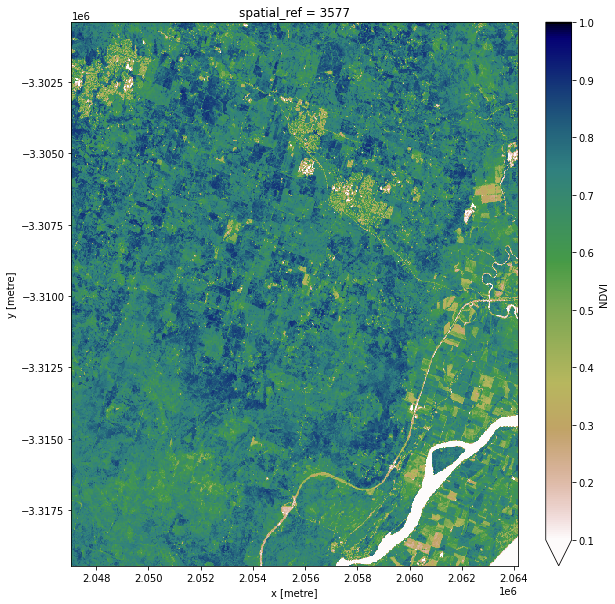

In [4]:
# First we calculate NDVI on each image in the timeseries
ndvi = calculate_indices(ds, index='NDVI', collection='ga_s2_1')

# For each pixel, calculate the mean NDVI throughout the whole timeseries
ndvi = ndvi.mean(dim='time', keep_attrs=True)

# Plot the results to inspect
ndvi.NDVI.plot(vmin=0.1, vmax=1.0, cmap='gist_earth_r', figsize=(10, 10))


## Quickshift Segmentation

Using the function [quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift) from the python package `scikit-image`, we will conduct an image segmentation on the mean NDVI array.  We then calculate a zonal mean across each segment using the input dataset. Our last step is to export our results as a GeoTIFF.

Follow the quickshift hyperlink above to see the input parameters to the algorithm, and the following [link](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html) for an explanation of quickshift and other segmentation algorithms in `scikit-image`.

In [5]:
# Convert our mean NDVI xarray into a numpy array, we need
# to be explicit about the datatype to satisfy quickshift
input_array = ndvi.NDVI.values.astype(np.float64)


In [6]:
# Calculate the segments
segments = quickshift(input_array,
                      kernel_size=5,
                      convert2lab=False,
                      max_dist=10,
                      ratio=1.0)


In [7]:
# Calculate the zonal mean NDVI across the segments
segments_zonal_mean_qs = scipy.ndimage.mean(input=input_array,
                                            labels=segments,
                                            index=segments)


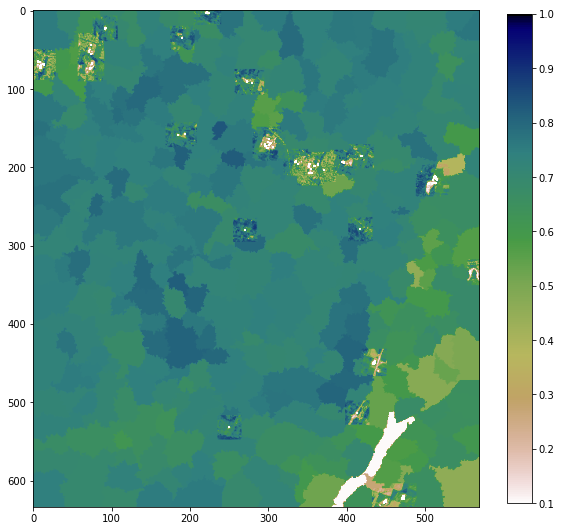

In [8]:
# Plot to see result
plt.figure(figsize=(10, 10))
plt.imshow(segments_zonal_mean_qs, cmap='gist_earth_r', vmin=0.1, vmax=1.0)
plt.colorbar(shrink=0.9)


### Export result to GeoTIFF
To export our result to a GeoTIFF raster file, we first need to convert our plain `np.array` back to an `xr.DataArray`, then use the `write_cog` function.

In [9]:
# Convert numpy array to xarray.DataArray
segments_zonal_mean_qs = xr.DataArray(segments_zonal_mean_qs, 
             coords=ndvi.coords, 
             dims=['y', 'x'], 
             attrs=ndvi.attrs)

# Write array to GeoTIFF
write_cog(geo_im=segments_zonal_mean_qs,
          fname='masked_data.tif',
          overwrite=True);

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [10]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)